In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd

In [ ]:
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values

# Preview original data

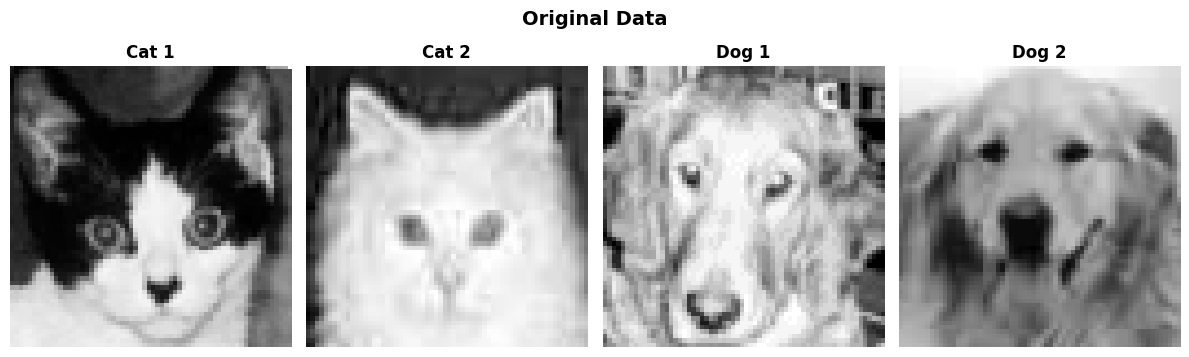

In [ ]:
def rotate_matrix(x):
    return np.flip(x.T, axis=1)

np.random.seed(1042212)

cats_indices = np.where(labels == 0)[0]
dogs_indices = np.where(labels == 1)[0]

sample_cats = np.random.choice(cats_indices, 2, replace=False)
sample_dogs = np.random.choice(dogs_indices, 2, replace=False)

gray_scale = LinearSegmentedColormap.from_list("grayscale", [(i/255, i/255, i/255) for i in range(256)], N=256)

# Plot original data
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
titles = ['Cat 1', 'Cat 2', 'Dog 1', 'Dog 2']
for i, idx in enumerate([sample_cats[0], sample_cats[1], sample_dogs[0], sample_dogs[1]]):
    axs[i].imshow(rotate_matrix(catsndogs[idx].reshape(64, 64)), cmap=gray_scale)
    axs[i].axis('off')
    axs[i].set_title(titles[i], fontweight='bold', fontsize=12)
fig.suptitle('Original Data', fontsize=14, fontweight='bold', verticalalignment='top', y=0.8)
plt.tight_layout()
plt.show()


# 1. Classifier 1: CNN
## 1.1 Train CNN

In [ ]:
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values

# Convert data to PyTorch tensors and create datasets
data = torch.tensor(catsndogs, dtype=torch.float32).reshape(-1, 1, 64, 64) / 255.0  # Normalize data
targets = torch.tensor(labels, dtype=torch.long).squeeze()
dataset = TensorDataset(data, targets)

# Split data into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# Define the CNN model
class CNN_arch(nn.Module):
    def __init__(self):
        super(CNN_arch, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 16 * 16, 100)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.act3(self.fc1(x))
        x = self.fc3(x)
        return x

model = CNN_arch()

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0
    train_correct = 0
    train_total = 0
    val_correct = 0
    val_total = 0

    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100*train_correct/train_total

    # Val
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100*val_correct/val_total

    print(f'Epoch {epoch+1}, Train Loss: {train_loss/train_total:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

Epoch 1, Train Loss: 0.0723, Train Accuracy: 47.47%, Val Accuracy: 67.50%
Epoch 2, Train Loss: 0.0692, Train Accuracy: 63.29%, Val Accuracy: 75.00%
Epoch 3, Train Loss: 0.0613, Train Accuracy: 81.65%, Val Accuracy: 82.50%
Epoch 4, Train Loss: 0.0466, Train Accuracy: 81.01%, Val Accuracy: 85.00%
Epoch 5, Train Loss: 0.0379, Train Accuracy: 84.81%, Val Accuracy: 77.50%
Epoch 6, Train Loss: 0.0352, Train Accuracy: 84.18%, Val Accuracy: 85.00%
Epoch 7, Train Loss: 0.0285, Train Accuracy: 89.87%, Val Accuracy: 90.00%
Epoch 8, Train Loss: 0.0235, Train Accuracy: 92.41%, Val Accuracy: 95.00%
Epoch 9, Train Loss: 0.0172, Train Accuracy: 94.30%, Val Accuracy: 70.00%
Epoch 10, Train Loss: 0.0246, Train Accuracy: 92.41%, Val Accuracy: 85.00%


## 1.2 Confusion matrix

In [ ]:

# Variables to hold predictions and actual labels
y_pred = []
y_true = []

# Validation loop with class-specific tracking
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(y_true, y_pred, target_names=['Cats', 'Dogs'])
print("\nClassification Report:\n", class_report)

Confusion Matrix:
 [[17  4]
 [ 2 17]]

Classification Report:
               precision    recall  f1-score   support

        Cats       0.89      0.81      0.85        21
        Dogs       0.81      0.89      0.85        19

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40



## 1.3 Display missclassified images

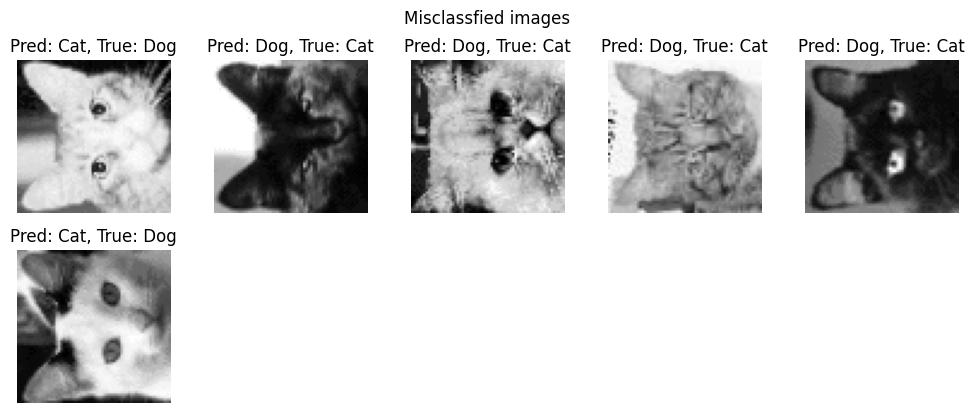

In [ ]:
misclassified_images = []
misclassified_pred = []
misclassified_true = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        misclassified_mask = predicted != labels

        # Collect misclassified images and labels
        if any(misclassified_mask):
            misclassified_images.extend(inputs[misclassified_mask].cpu().numpy())
            misclassified_pred.extend(predicted[misclassified_mask].cpu().numpy())
            misclassified_true.extend(labels[misclassified_mask].cpu().numpy())

# Function to plot misclassified images
def plot_misclassified(images, predicted, true_labels):
    plt.figure(figsize=(10, 10))
    num_images = len(images)
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        img = images[i].squeeze()
        plt.imshow(img, cmap='gray')
        if predicted[i] == 0:
              pred = 'Cat'
        else :
            pred = 'Dog'
        if true_labels[i] == 0:
          true_label = 'Cat'
        else:
          true_label = 'Dog'
        plt.title(f'Pred: {pred}, True: {true_label}')
        plt.axis('off')
    plt.suptitle('Misclassfied images')
    plt.tight_layout()
    plt.show()

# Plotting the misclassified images
plot_misclassified(misclassified_images, misclassified_pred, misclassified_true)


In [ ]:
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values

X_train, X_test, y_train, y_test = train_test_split(catsndogs, labels.ravel(), test_size=0.2)

# SVM

In [ ]:

from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
def misclassified_svm(y_true, y_pred, X_test):
    # Find indices where predictions and true labels don't match
    misclassified_indices = np.where(y_pred != y_true)[0]

    # Extract misclassified images based on these indices
    misclassified_images = [X_test[i] for i in misclassified_indices]

    # Get the predicted labels for these misclassified images
    misclassified_preds = y_pred[misclassified_indices]

    # Get the true labels for these misclassified images
    misclassified_trues = y_true[misclassified_indices]

    return misclassified_images, misclassified_preds, misclassified_trues


# Function to plot misclassified images
def plot_misclassified_svm(images, predicted, true_labels):
    if images:  # Check if the list is not empty
        plt.figure(figsize=(10, 10))
        num_images = len(images)
        num_to_plot = min(num_images, 25)  # Plot at most 25 images
        for i in range(num_to_plot):
            plt.subplot(5, 5, i + 1)  # Arranging plots in a 5x5 grid
            img_shape = int(np.sqrt(images[i].size))  # Assuming the images are square
            img = images[i].reshape((img_shape, img_shape))  # Reshape flat array to 2D
            plt.imshow(img, cmap='gray')
            if predicted[i] == 0:
              pred = 'Cat'
            else :
                pred = 'Dog'
            if true_labels[i] == 0:
              true_label = 'Cat'
            else:
              true_label = 'Dog'
            plt.title(f'Pred: {pred}, True: {true_label}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified images to display.")

# Plotting the misclassified images
# plot_misclassified(misclassified_images, misclassified_pred, misclassified_true)


Confusion Matrix:
 [[16  4]
 [ 4 16]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        20
           1       0.80      0.80      0.80        20

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



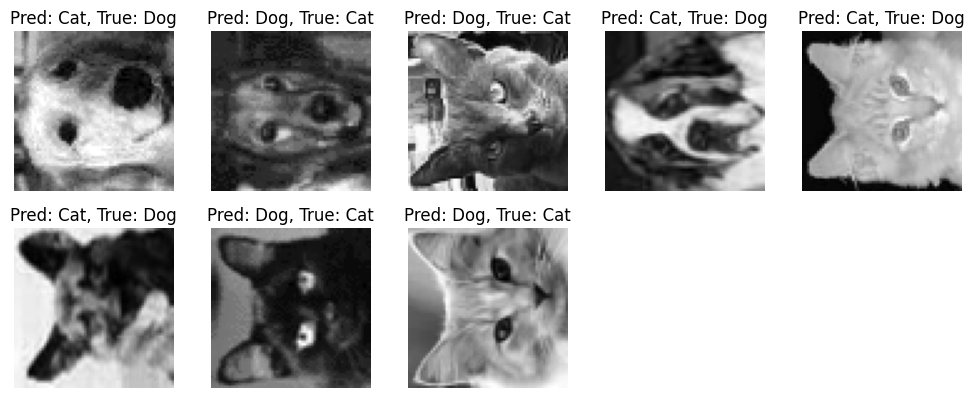

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(catsndogs, labels.ravel(), test_size=0.2)
# Can change parameters
svm_classifier_rbf = svm.SVC(kernel='rbf', gamma='scale', C=100.)

# Train the classifier
svm_classifier_rbf.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier_rbf.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Evaluate the model
print(classification_report(y_test, y_pred))

misclassified_images, misclassified_preds, misclassified_trues = misclassified_svm(y_test, y_pred, X_test)
plot_misclassified_svm(misclassified_images, misclassified_preds, misclassified_trues)


# kNN


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Load data
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values.ravel()  # Flatten label array

# Flatten each image from (64, 64) to (4096,)
catsndogs_flattened = catsndogs.reshape(-1, 64*64) / 255.0  # Normalize data

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(catsndogs_flattened, labels, test_size=0.2, random_state=42)

In [ ]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can experiment with different values

# Train the model (KNN doesn't really "train", it just stores the data)
knn.fit(X_train, y_train)

# Predict on validation set
y_pred = knn.predict(X_val)

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(y_val, y_pred, target_names=['Cats', 'Dogs'])
print("\nClassification Report:\n", class_report)


Confusion Matrix:
 [[12  5]
 [ 4 19]]

Classification Report:
               precision    recall  f1-score   support

        Cats       0.75      0.71      0.73        17
        Dogs       0.79      0.83      0.81        23

    accuracy                           0.78        40
   macro avg       0.77      0.77      0.77        40
weighted avg       0.77      0.78      0.77        40



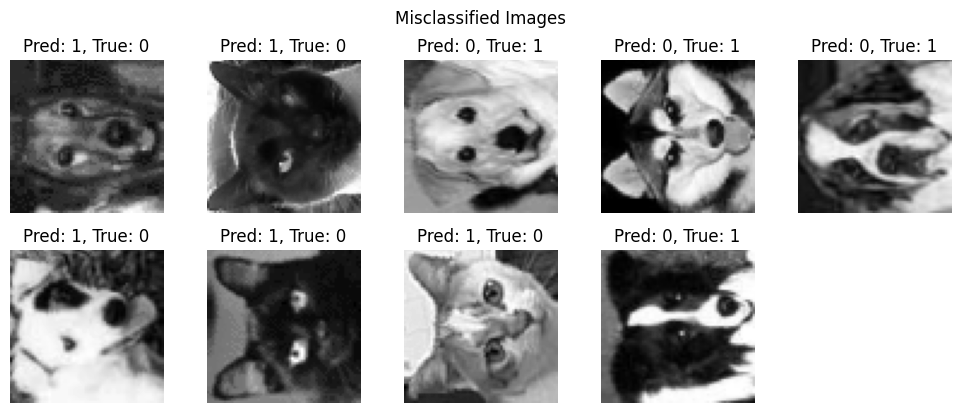

In [ ]:
# Finding misclassified images
misclassified_idx = np.where(y_pred != y_val)[0]
misclassified_images = X_val[misclassified_idx].reshape(-1, 64, 64)
misclassified_pred = y_pred[misclassified_idx]
misclassified_true = y_val[misclassified_idx]

# Function to plot misclassified images
def plot_misclassified(images, predicted, true_labels):
    plt.figure(figsize=(10, 10))
    num_images = len(images)
    for i in range(min(num_images, 25)):  # Show up to 25 misclassified images
        plt.subplot(5, 5, i + 1)
        img = images[i]
        plt.imshow(img, cmap='gray')
        plt.title(f'Pred: {predicted[i]}, True: {true_labels[i]}')
        plt.axis('off')
    plt.suptitle('Misclassified Images')
    plt.tight_layout()
    plt.show()

# Plotting the misclassified images
plot_misclassified(misclassified_images, misclassified_pred, misclassified_true)


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

Confusion Matrix:
 [[15  5]
 [ 5 15]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.75      0.75      0.75        20

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40



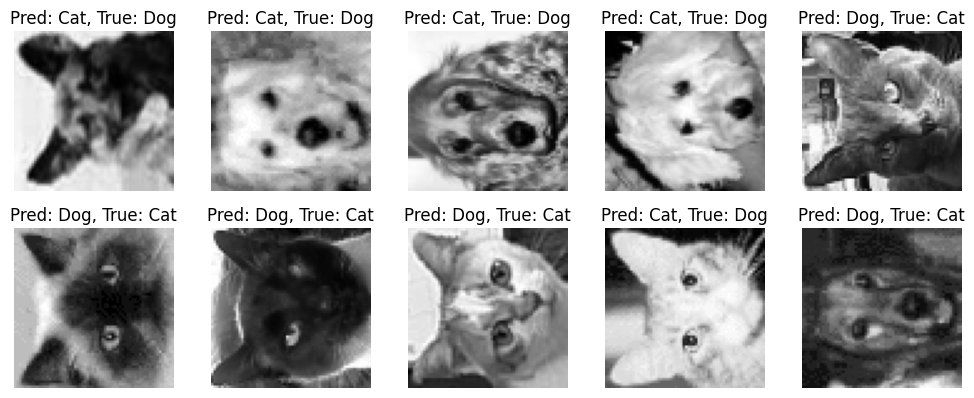

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(catsndogs, labels.ravel(), test_size=0.2)
# Create a logistic regression model
LR_classifier = LogisticRegression(max_iter=500, solver='lbfgs')  # Increase max_iter if convergence warning appears

# Train the model
LR_classifier.fit(X_train, y_train)

# Make prediction
y_pred_LR = LR_classifier.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_LR)
print("Confusion Matrix:\n", conf_matrix)

# Evaluate the model
print(classification_report(y_test, y_pred_LR))

misclassified_images, misclassified_preds, misclassified_trues = misclassified_svm(y_test, y_pred_LR, X_test)
plot_misclassified_svm(misclassified_images, misclassified_preds, misclassified_trues)

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

Confusion Matrix:
 [[12  6]
 [ 3 19]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        18
           1       0.76      0.86      0.81        22

    accuracy                           0.78        40
   macro avg       0.78      0.77      0.77        40
weighted avg       0.78      0.78      0.77        40



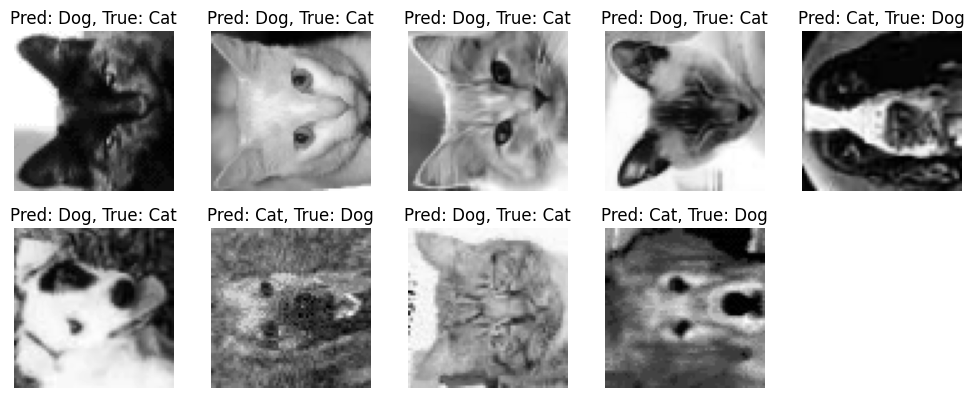

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(catsndogs, labels.ravel(), test_size=0.2)
# Initialize the Gaussian Naive Bayes classifier
NB_classifier = GaussianNB()

# Train the model
NB_classifier.fit(X_train, y_train)

# Predict the test set results
y_pred_NB = NB_classifier.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_NB)
print("Confusion Matrix:\n", conf_matrix)

# Evaluate the model
print(classification_report(y_test, y_pred_NB))

misclassified_images, misclassified_preds, misclassified_trues = misclassified_svm(y_test, y_pred_NB, X_test)
plot_misclassified_svm(misclassified_images, misclassified_preds, misclassified_trues)